In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
customers = pd.read_csv("Ecommerce/olist_customers_dataset.csv")
order_items = pd.read_csv("Ecommerce/olist_order_items_dataset.csv")
orders = pd.read_csv("Ecommerce/olist_orders_dataset.csv")
products = pd.read_csv("Ecommerce/olist_products_dataset.csv")
reviews = pd.read_csv("Ecommerce/olist_order_reviews_dataset.csv")
sellers = pd.read_csv("Ecommerce/olist_sellers_dataset.csv")


In [40]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [3]:
display(customers.count()) # 99441

# orders의 결측치
display(orders.isna().sum())

customer_id                 99441
customer_unique_id          99441
customer_zip_code_prefix    99441
customer_city               99441
customer_state              99441
dtype: int64

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

# 결측치

In [4]:
# 결측치 항목들부터 확인
orders[orders[['order_approved_at']].isna().any(axis=1)] # 주문자가 취소한 건 -> 그냥 없애
orders[orders[['order_delivered_carrier_date']].isna().any(axis=1)] # 배송 시작이 안 됐는디...?
orders[orders[['order_delivered_customer_date']].isna().any(axis=1)] # 배송 완료가 없음...


# 1. 주문자가 canceled한 order_status는 그냥 없애고 시작
orders = orders[orders['order_status'] != 'canceled']

#order_status가 delivered면	order_approved_at 값은 order_purchase_timestamp로 채움
orders.loc[(orders['order_status'] == 'delivered') & 
           (orders['order_approved_at'].isnull()), 'order_approved_at'] = orders['order_purchase_timestamp']

display(orders.isna().sum())



# 주문df와 리뷰df 병합
orders_reviews = orders.merge(reviews, on='order_id', how='left')


# 2. 배송 시작은 null 인데 배송 완료가 된 건이 있는지       ->  1건
weird_delivery = orders[
    orders['order_delivered_carrier_date'].isna() & 
    orders['order_delivered_customer_date'].notna()
]

print("배송시작 NULL인데 배송완료는 있는 건수:", len(weird_delivery))
weird_delivery.head()

weird_delivery = orders_reviews[
    orders_reviews['order_delivered_carrier_date'].isna() &
    orders_reviews['order_delivered_customer_date'].notna()
]

avg_delivery_score = weird_delivery['review_score'].mean()
print("배송시작 NaN + 배송완료 존재 평균 리뷰점수:", avg_delivery_score)


# 배송 완료 됐으니까 데이터 누락일 뿐임. 그냥 승인일로 채우고 시작
orders.loc[
    orders['order_delivered_carrier_date'].isna() & 
    orders['order_delivered_customer_date'].notna(),
    'order_delivered_carrier_date'
] = orders['order_approved_at']


order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   5
order_delivered_carrier_date     1233
order_delivered_customer_date    2346
order_estimated_delivery_date       0
dtype: int64

배송시작 NULL인데 배송완료는 있는 건수: 1
배송시작 NaN + 배송완료 존재 평균 리뷰점수: 5.0


In [ ]:
# 승인이 null인 5건을 찾아서...
orders_reviews[orders_reviews['order_approved_at'].isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
7429,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,NaN,NaN,NaN,2018-01-11 00:00:00,094b5d5ffff5d37b6195b4674ac84362,1.0,NaN,o PRODUTO NÃO CHEGOU ATÉ HOJE.,2018-01-13 00:00:00,2018-01-14 23:15:02
9235,dba5062fbda3af4fb6c33b1e040ca38f,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04,NaN,NaN,NaN,2018-03-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
21429,7a4df5d8cff4090e541401a20a22bb80,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33,NaN,NaN,NaN,2017-12-12 00:00:00,64b53acf68ca2e45eebb01436a911982,1.0,NaN,NaN,2017-12-15 00:00:00,2017-12-15 13:33:49
55016,35de4050331c6c644cddc86f4f2d0d64,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05 01:07:58,NaN,NaN,NaN,2018-01-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
58884,90ab3e7d52544ec7bc3363c82689965f,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06 13:12:34,NaN,NaN,NaN,2017-12-01 00:00:00,ce24a21f96199f7e7257d5346f387e5f,5.0,NaN,Embora o produto estivesse em falta a empresa ...,2017-12-06 00:00:00,2017-12-06 10:17:34


In [ ]:
# 주문 상태가 created이고, order_approved_at은 null인 사람 중에 
# 리뷰를 쓴 사람이 있는지 확인
created_with_reviews = orders_reviews[
    (orders_reviews['order_status'] == 'created') &
    (orders_reviews['order_approved_at'].isna()) &
    (orders_reviews['review_id'].notna())
]

# 결과 출력
if created_with_reviews.empty:
    print("'created' 상태의 주문 중 리뷰를 쓴 사람은 없습니다.")
else:
    print("'created' 상태의 주문 중 리뷰를 쓴 사람의 데이터는 다음과 같습니다:")
    print(created_with_reviews['review_score'])
    print(f"\n총 {len(created_with_reviews)}건의 리뷰가 있습니다.")


# 일단 문제가 있다는 건 확인. 
# 감정 분석을 배웠다면 리뷰 내용을 파악해 분석해보아도 좋았을 것 같다.

'created' 상태의 주문 중 리뷰를 쓴 사람의 데이터는 다음과 같습니다:
7429     1.0
21429    1.0
58884    5.0
Name: review_score, dtype: float64

총 3건의 리뷰가 있습니다.


In [66]:
# 1. 배송 시작이 NaN인데 리뷰 점수 있는 경우
weird_carrier = orders_reviews[
    orders_reviews['order_delivered_carrier_date'].isna() &
    orders_reviews['review_score'].notna()
]

print("🚚 배송시작 NULL + 리뷰 있음 건수:", len(weird_carrier))
print("평균 리뷰 점수:", weird_carrier['review_score'].mean().round(2))


# 2️. 배송 완료가 NaN인데 리뷰 점수 있는 경우
weird_customer = orders_reviews[
    orders_reviews['order_delivered_customer_date'].isna() &
    orders_reviews['review_score'].notna()
]

print("\n📦 배송완료 NULL + 리뷰 있음 건수:", len(weird_customer))
print("평균 리뷰 점수:", weird_customer['review_score'].mean().round(2))


# 3. 정상 배송된 주문 평균 리뷰점수
delivered_avg = orders_reviews[
    orders_reviews['order_delivered_customer_date'].notna()
]['review_score'].mean()

print("\n정상 배송 평균 리뷰점수:", (delivered_avg).round(2))



# 물건을 못 받았는데 리뷰를 남겼다? 리뷰 평균 점수가 낮으니까 미배송건(배송실패)이라고 해석
# delivery_status 컬럼 초기화
orders_reviews['delivery_status'] = '배송완료'

# 1️⃣ 배송 완료가 NaN이고 리뷰가 3점 이하 → 배송실패
mask_fail = orders_reviews['order_delivered_customer_date'].isna() & (orders_reviews['review_score'] <= 3)
orders_reviews.loc[mask_fail, 'delivery_status'] = '배송실패'

# 2️⃣ 배송 완료가 NaN이고 리뷰가 4점 이상 → 배송기록누락
mask_missing = orders_reviews['order_delivered_customer_date'].isna() & (orders_reviews['review_score'] >= 4)
orders_reviews.loc[mask_missing, 'delivery_status'] = '배송기록누락'

# 3️⃣ 참고: 배송기록누락인 경우, order_approved_at으로 배송일 채우기
orders_reviews.loc[mask_missing, 'order_delivered_customer_date'] = orders_reviews.loc[mask_missing, 'order_approved_at']

# 확인
display(orders_reviews.head())
print("배송실패 건수:", orders_reviews[orders_reviews['delivery_status'] == '배송실패']['order_id'].count())
print("배송기록누락 건수:", orders_reviews[orders_reviews['delivery_status'] == '배송기록누락']['order_id'].count())



🚚 배송시작 NULL + 리뷰 있음 건수: 1213
평균 리뷰 점수: 1.51

📦 배송완료 NULL + 리뷰 있음 건수: 1934
평균 리뷰 점수: 1.26

정상 배송 평균 리뷰점수: 4.16


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,delivery_status,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,배송완료,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,배송완료,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,배송완료,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58,배송완료,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51,배송완료,SP


배송실패 건수: 1933
배송기록누락 건수: 1


In [8]:
# orders_reviews = orders_reviews.drop(['customer_state_x', 'customer_state_y'], axis=1)

In [ ]:
# 1️⃣ 고객 정보 merge (state 포함)
orders_reviews = orders_reviews.merge(customers[['customer_id','customer_state']], on='customer_id', how='left')
orders_reviews.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,delivery_status,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,배송완료,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,배송완료,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,배송완료,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58,배송완료,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51,배송완료,SP


,customer_state,배송실패건수,전체건수,배송실패율(%)
25,SP,767,41635,1.842200
18,RJ,355,12843,2.764152
10,MG,181,11642,1.554716


,customer_state,배송실패건수,전체건수,배송실패율(%)
0,AC,1,81,1.234568
3,AP,1,68,1.470588
21,RR,4,45,8.888889


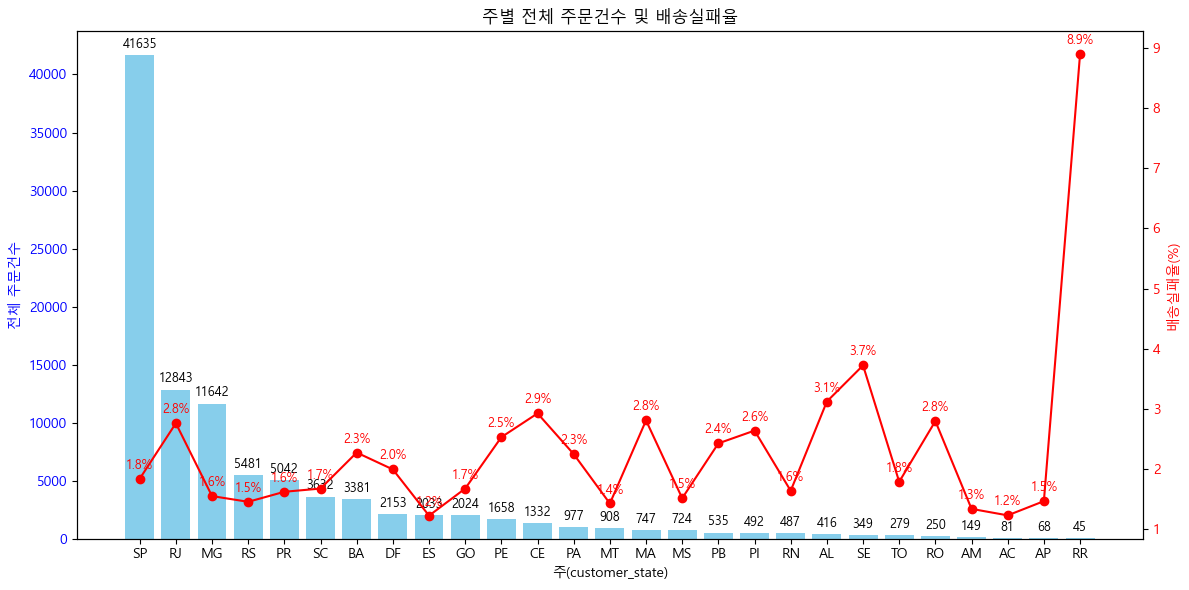

In [ ]:
# 배송실패 주문만 필터링
failed_orders = orders_reviews[orders_reviews['delivery_status']=='배송실패']

# 주별 배송실패 건수 집계
failed_by_state = failed_orders.groupby('customer_state').size().reset_index(name='배송실패건수')

# 전체 주문 대비 실패율 계산
total_by_state = orders_reviews.groupby('customer_state').size().reset_index(name='전체건수')
failed_by_state = failed_by_state.merge(total_by_state, on='customer_state', how='left')
failed_by_state['배송실패율(%)'] = (failed_by_state['배송실패건수'] / failed_by_state['전체건수']) * 100

# 결과 확인
display(failed_by_state.sort_values(['전체건수', '배송실패율(%)'], ascending=False).head(3))
display(failed_by_state.sort_values(['전체건수', '배송실패율(%)'], ascending=False).tail(3))




# 데이터 정렬 (전체건수 많은 순으로)
plot_df = failed_by_state.sort_values('전체건수', ascending=False)

fig, ax1 = plt.subplots(figsize=(12,6))

# 1️⃣ 막대그래프 (전체 주문건수)
bars = ax1.bar(plot_df['customer_state'], plot_df['전체건수'], color='skyblue', label='전체 주문건수')
ax1.set_xlabel('주(customer_state)')
ax1.set_ylabel('전체 주문건수', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 2️⃣ 실패율 라인그래프 (오른쪽 y축)
ax2 = ax1.twinx()
ax2.plot(plot_df['customer_state'], plot_df['배송실패율(%)'], color='red', marker='o', label='배송실패율(%)')
ax2.set_ylabel('배송실패율(%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 3️⃣ 막대 위에 전체건수 표시
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{int(height)}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

# 4️⃣ 실패율 점 위에 숫자 표시
for i, rate in enumerate(plot_df['배송실패율(%)']):
    ax2.annotate(f'{rate:.1f}%',
                 xy=(i, rate),
                 xytext=(0, 5), textcoords="offset points",
                 ha='center', va='bottom', fontsize=9, color='red')

plt.title('주별 전체 주문건수 및 배송실패율')
fig.tight_layout()
plt.show()

In [119]:
print('''
1️⃣ 주문량 대비 실패율

SP, RJ, MG: 주문량 많음 (SP 41,635건, RJ 12,843건, MG 11,642건)
실패율은 1~2% 수준 → 대형 주는 물류 안정성 높음
즉, 주문량 많아도 실패율은 낮음 → 물류 시스템 잘 갖춰져 있음

반대로, RR, SE, AL, CE, MA, RO: 주문량 적음
소수 주문인데도 배송실패율 높음 → 소규모 지역에서 물류 취약

2️⃣ 우선 개선 필요 지역

RR, SE, AL, CE, MA, RO → 배송실패율 2.8% 이상
주문량 많지 않지만, 실패율 높으므로 물류 전략/배송 파트너 재검토 필요

3️⃣ 시사점

대형 주(SP, RJ, MG) → 현재 물류 안정적, 마케팅/프로모션 집중 가능
중소/외곽 주(RR, SE, AL, CE, MA, RO) → 배송 개선, 배송 파트너 점검, 고객 커뮤니케이션 강화 필요
배송실패율 + 주문량 같이 시각화하면, 우선 순위 지역 선정 용이''')


1️⃣ 주문량 대비 실패율

SP, RJ, MG: 주문량 많음 (SP 41,635건, RJ 12,843건, MG 11,642건)
실패율은 1~2% 수준 → 대형 주는 물류 안정성 높음
즉, 주문량 많아도 실패율은 낮음 → 물류 시스템 잘 갖춰져 있음

반대로, RR, SE, AL, CE, MA, RO: 주문량 적음
소수 주문인데도 배송실패율 높음 → 소규모 지역에서 물류 취약

2️⃣ 우선 개선 필요 지역

RR, SE, AL, CE, MA, RO → 배송실패율 2.8% 이상
주문량 많지 않지만, 실패율 높으므로 물류 전략/배송 파트너 재검토 필요

3️⃣ 시사점

대형 주(SP, RJ, MG) → 현재 물류 안정적, 마케팅/프로모션 집중 가능
중소/외곽 주(RR, SE, AL, CE, MA, RO) → 배송 개선, 배송 파트너 점검, 고객 커뮤니케이션 강화 필요
배송실패율 + 주문량 같이 시각화하면, 우선 순위 지역 선정 용이


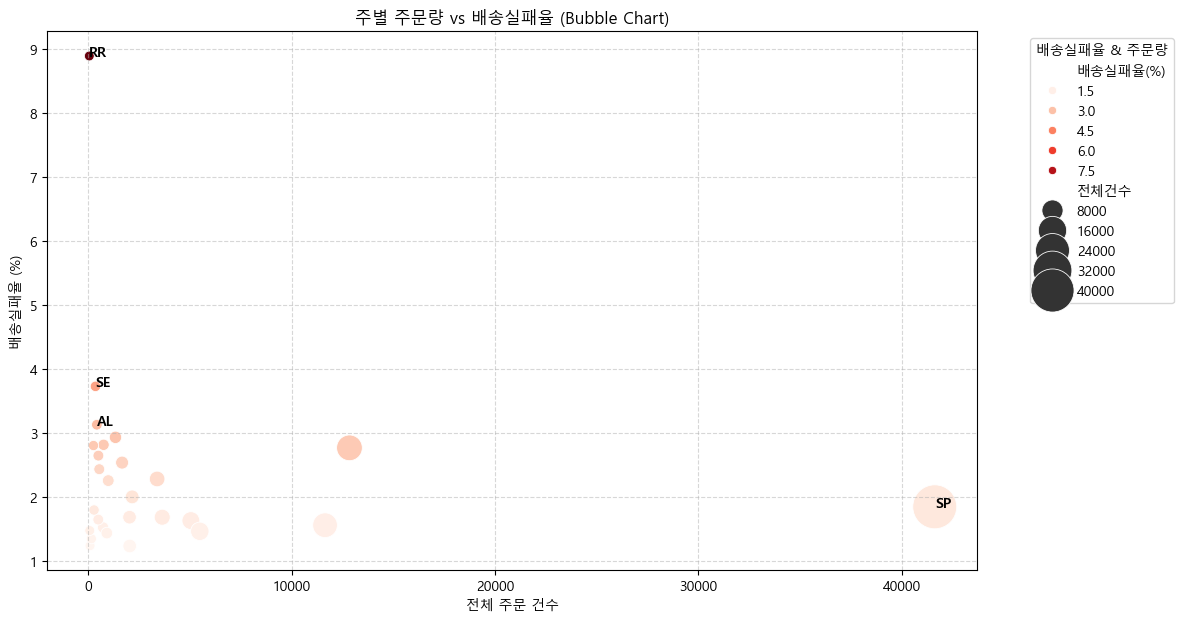

In [18]:
# orders_reviews 기반 주별 배송실패율 테이블
# failed_by_state 컬럼: customer_state, 배송실패건수, 전체건수, 배송실패율(%)

plt.figure(figsize=(12,7))
sns.scatterplot(
    data=failed_by_state,
    x='전체건수',
    y='배송실패율(%)',
    size='전체건수',         # 점 크기로 주문량 표시
    hue='배송실패율(%)',     # 색상으로 실패율 강조
    palette='Reds',
    sizes=(50, 1000),
    legend='brief'
)

# 주석 달기 (상위 실패율 주 표시)
for i, row in failed_by_state.iterrows():
    if row['배송실패율(%)'] > 3:  # 임계값: 3% 이상
        plt.text(row['전체건수'], row['배송실패율(%)'], row['customer_state'],
                 horizontalalignment='left', size='medium', color='black', weight='semibold')

# SP 주석 추가
sp_row = failed_by_state[failed_by_state['customer_state']=='SP'].iloc[0]
plt.text(sp_row['전체건수'], sp_row['배송실패율(%)'], 'SP',
         horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title("주별 주문량 vs 배송실패율 (Bubble Chart)")
plt.xlabel("전체 주문 건수")
plt.ylabel("배송실패율 (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='배송실패율 & 주문량', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [23]:
# 배송 성공한 애들만 데이터 분리!
success_orders = orders_reviews[orders_reviews['delivery_status']=='배송완료'].copy()


# 데이터 타입 변환
success_orders['order_purchase_timestamp'] = pd.to_datetime(success_orders['order_purchase_timestamp']) # 주문 시간
success_orders['order_approved_at'] = pd.to_datetime(success_orders['order_approved_at']) # 주문 승인 시간
success_orders['order_delivered_carrier_date'] = pd.to_datetime(success_orders['order_delivered_carrier_date']) # 배송사 출발 시간
success_orders['order_delivered_customer_date'] = pd.to_datetime(success_orders['order_delivered_customer_date']) # 배송 완료 시간
success_orders['order_estimated_delivery_date'] = pd.to_datetime(success_orders['order_estimated_delivery_date']) # 예상시간


# 주문 → 배송까지 시간 (일 단위)
success_orders['배송소요일'] = (
    success_orders['order_delivered_customer_date'] - success_orders['order_purchase_timestamp']
).dt.total_seconds() / (60*60*24)  # 초 → 일

# 배송 지연 여부
success_orders['배송지연'] = (
    success_orders['order_delivered_customer_date'] - success_orders['order_estimated_delivery_date']
).dt.total_seconds() / (60*60*24)  # 일 단위
success_orders['지연여부'] = success_orders['배송지연'] > 0

display(success_orders.head())



,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,delivery_status,customer_state,배송소요일,배송지연,지연여부
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,배송완료,SP,8.436574,-7.107488,False
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,배송완료,BA,13.782037,-5.355729,False
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,배송완료,GO,9.394213,-17.245498,False
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58,배송완료,RN,13.208750,-12.980069,False
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51,배송완료,SP,2.873877,-9.238171,False


,customer_state,평균배송소요일,배송지연율,평균리뷰점수
25,SP,8.764857,0.058735,4.246164
17,PR,12.000591,0.050152,4.238260
10,MG,12.011948,0.055988,4.192707
6,DF,12.996125,0.070919,4.131642
23,SC,14.975162,0.097725,4.131050
18,RJ,15.318877,0.134566,3.963439
22,RS,15.319540,0.071681,4.185344
8,GO,15.604079,0.081984,4.102904
11,MS,15.629538,0.115169,4.169014
7,ES,15.798111,0.122195,4.082406


C:\Users\agnes\AppData\Local\Temp\ipykernel_17420\13469287.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


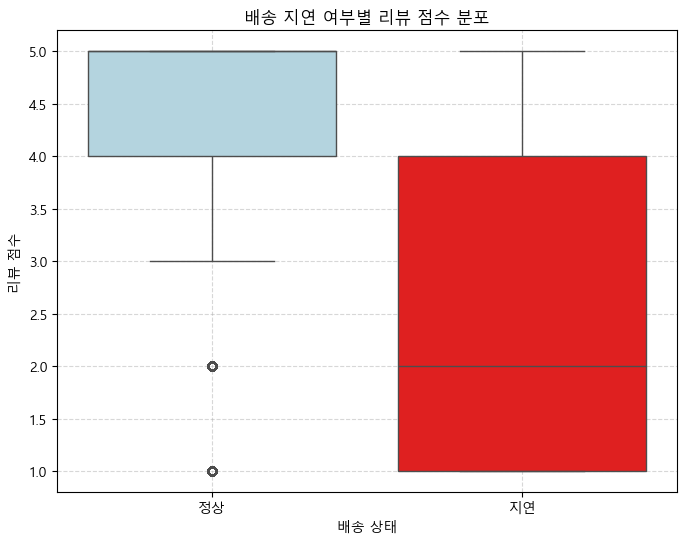

In [24]:

# 지역별 배송 성과 분석
region_perf = success_orders.groupby('customer_state').agg({
    '배송소요일': 'mean',
    '지연여부': 'mean',       # 지연율
    'review_score': 'mean'
}).reset_index()

region_perf.rename(columns={
    '배송소요일': '평균배송소요일',
    '지연여부': '배송지연율',
    'review_score': '평균리뷰점수'
}, inplace=True)

display(region_perf.sort_values('평균배송소요일'))


# 지연 여부에 따른 리뷰 점수 boxplot !!!!!!!!!!!!!!!!!!!!!!!
plt.figure(figsize=(8,6))
sns.boxplot(
    data=success_orders,
    x='지연여부',
    y='review_score',
    palette=['lightblue', 'red']  # 각각 색 다르게
)

# X축 레이블 변경
plt.xticks([0, 1], ['정상', '지연'])

plt.xlabel("배송 상태")
plt.ylabel("리뷰 점수")
plt.title("배송 지연 여부별 리뷰 점수 분포")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [26]:
# 전체 주문 건수 집계
order_count = success_orders.groupby('customer_state').size().reset_index(name='전체건수')

# region_perf에 merge
region_perf = region_perf.merge(order_count, on='customer_state')

# region_perf = region_perf.drop(columns=['전체건수_x', '전체건수_y'], errors='ignore')

region_perf

,customer_state,평균배송소요일,배송지연율,평균리뷰점수,전체건수
0,AC,21.035713,0.037500,4.087500,80
1,AL,24.536053,0.239401,3.841709,401
2,AM,26.383431,0.040816,4.220690,147
3,AP,27.185068,0.044776,4.242424,67
4,BA,19.356057,0.140292,3.929452,3286
5,CE,21.268040,0.153188,3.938088,1286
6,DF,12.996125,0.070919,4.131642,2101
7,ES,15.798111,0.122195,4.082406,2005
8,GO,15.604079,0.081984,4.102904,1976
9,MA,21.521970,0.195562,3.839385,721


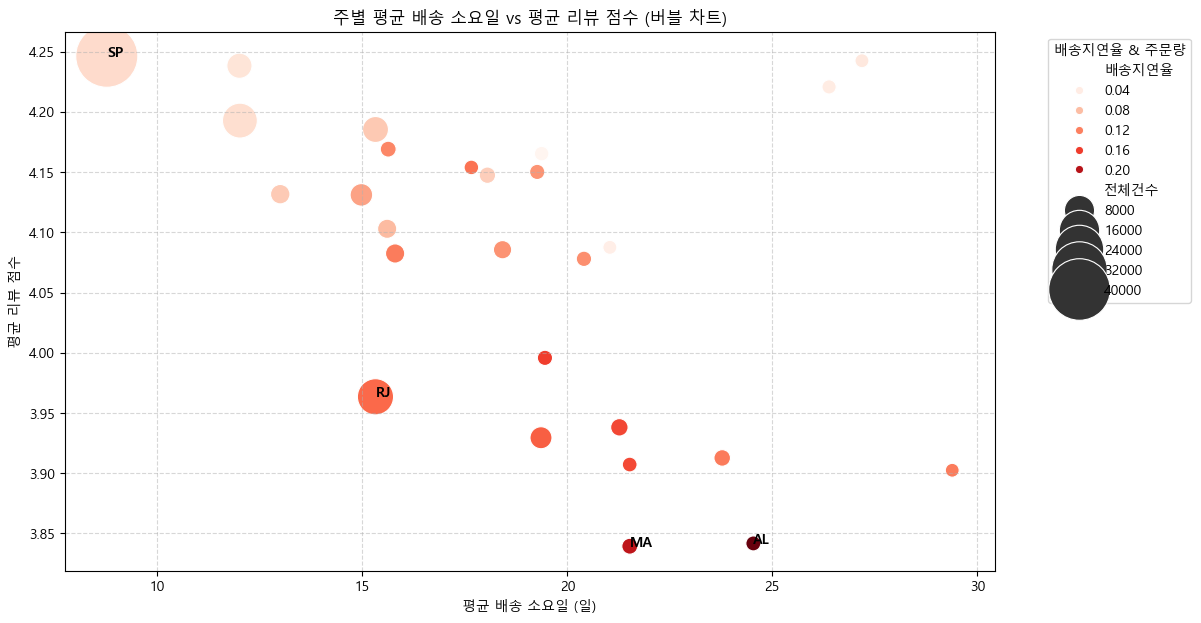

In [27]:

plt.figure(figsize=(12,7))
sns.scatterplot(
    data=region_perf,
    x='평균배송소요일',
    y='평균리뷰점수',
    size='전체건수',   # 점 크기로 주문량 표시
    hue='배송지연율',         # 색상으로 지연율 강조
    palette='Reds',
    sizes=(100, 2000),
    legend='brief'
)

# 주요 주 주석 추가 (예: 주문량 많거나 지연율 높은 주)
for i, row in region_perf.iterrows():
    if row['customer_state'] in ['SP','RJ','AL','MA']:  # 눈에 띄는 주
        plt.text(row['평균배송소요일'], row['평균리뷰점수'], row['customer_state'],
                 horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title("주별 평균 배송 소요일 vs 평균 리뷰 점수 (버블 차트)")
plt.xlabel("평균 배송 소요일 (일)")
plt.ylabel("평균 리뷰 점수")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='배송지연율 & 주문량', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
'''

SP (São Paulo) → 서울/경기권
인구 많고 경제 중심, 상업/산업 집중

PR (Paraná / Curitiba) → 부산
산업과 농업이 발달, 인구 규모 큰 항구 도시 중심

MG (Minas Gerais / Belo Horizonte) → 대구
인구 많고 산업 활동 활발, 내륙 중심

----
RJ (Rio de Janeiro) 어떻게 할건데 !!!!!!!!!!!!!!!!!!!!!!

브라질 남동부, 해안 도시 중심
인구 많고 상업/관광 집중 → 주문량 많음
도로 교통 혼잡, 지형이 산·해안으로 복잡 → 배송 소요 길어짐
즉, 주문량은 많지만 물류 인프라와 지형적 제약 때문에 배송 소요가 상대적으로 길어지는 지역이에요.

-----

RR (Roraima)
북쪽 끝, 인구 매우 적음 

AP (Amapá)
북동쪽, 아마존 근처, 인구 적음 → 한국 기준 강원도 일부 산간/섬 지역

AM (Amazonas)
아마존 숲 중심, 주도는 Manaus, 인구 일부 집중 → 강원도/경상 내륙 느낌

AL (Alagoas)
북동쪽 해안 소규모 주, 인구 적음 → 한국 기준 전남 일부 소도시 느낌

즉 이 지역들은 인구가 적고 외곽이어서 주문량/배송 실패율이 낮거나 특수한 패턴이 나오는 곳이에요.

1️⃣ 평균 배송 소요일

SP, PR, MG, DF → 8~13일 정도, 비교적 빠른 배송
RR, AP, AM, AL → 24~29일, 상당히 긴 배송 소요일
특히 RR(29.4일), AP(27.2일), AM(26.4일), AL(24.4일) → 물류망 취약, 배송 개선 필요

2️⃣ 배송 지연율

주문량 많은 대형 주(SP, RJ, MG)
SP: 5.85%, MG: 5.58%, RJ: 13.4%
SP, MG는 지연율 낮음 → 물류 안정적

RJ 지연율 상대적으로 높음 → 주문량 많아서 배송 압박 가능

외곽/소규모 주
AL: 23.8% → 배송 지연 심각
PI, CE, SE: 15~16% → 중간 수준 지연

3️⃣ 평균 리뷰 점수

대형 주(SP, PR, MG, DF) → 4점 이상, 비교적 높은 만족도
배송 지연 심한 주(AL, MA, SE, BA) → 3.8~3.9점, 리뷰 점수 낮음
배송 지연과 리뷰 점수 하락 간 연관성 확인 가능

4️⃣ 배송 지연 vs 리뷰 점수 관계

평균 배송 소요일이나 지연율이 높을수록 리뷰 점수는 하락 경향
AL, MA, SE, BA, CE → 지연 높고 리뷰 낮음
SP, PR, MG → 지연 낮고 리뷰 높음
→ 배송 지연이 고객 만족도(리뷰)와 직결됨을 보여줌

5️⃣ 전략적 시사점

대형 주(SP, MG, PR) → 현재 배송 안정적, 마케팅/프로모션 강화 가능

배송 지연 높은 주(AL, MA, SE, CE, PI, BA)
 -물류망 개선 필요
 -지연 최소화를 위한 배송 파트너 재점검, 재고 관리, 사전 알림

리뷰 점수와 배송 소요일 연관성
 -지연 감소 → 리뷰 점수 상승 → 고객 만족도 향상 → 장기적으로 재구매율 증가 가능
'''

'\n1️⃣ 평균 배송 소요일\n\nSP, PR, MG, DF → 8~13일 정도, 비교적 빠른 배송\nRR, AP, AM, AL → 24~29일, 상당히 긴 배송 소요일\n특히 RR(29.4일), AP(27.2일), AM(26.4일), AL(24.4일) → 물류망 취약, 배송 개선 필요\n\n2️⃣ 배송 지연율\n\n주문량 많은 대형 주(SP, RJ, MG)\nSP: 5.85%, MG: 5.58%, RJ: 13.4%\nSP, MG는 지연율 낮음 → 물류 안정적\n\nRJ 지연율 상대적으로 높음 → 주문량 많아서 배송 압박 가능\n\n외곽/소규모 주\nAL: 23.8% → 배송 지연 심각\nPI, CE, SE: 15~16% → 중간 수준 지연\n\n3️⃣ 평균 리뷰 점수\n\n대형 주(SP, PR, MG, DF) → 4점 이상, 비교적 높은 만족도\n배송 지연 심한 주(AL, MA, SE, BA) → 3.8~3.9점, 리뷰 점수 낮음\n배송 지연과 리뷰 점수 하락 간 연관성 확인 가능\n\n4️⃣ 배송 지연 vs 리뷰 점수 관계\n\n평균 배송 소요일이나 지연율이 높을수록 리뷰 점수는 하락 경향\nAL, MA, SE, BA, CE → 지연 높고 리뷰 낮음\nSP, PR, MG → 지연 낮고 리뷰 높음\n→ 배송 지연이 고객 만족도(리뷰)와 직결됨을 보여줌\n\n5️⃣ 전략적 시사점\n\n대형 주(SP, MG, PR) → 현재 배송 안정적, 마케팅/프로모션 강화 가능\n\n배송 지연 높은 주(AL, MA, SE, CE, PI, BA)\n -물류망 개선 필요\n -지연 최소화를 위한 배송 파트너 재점검, 재고 관리, 사전 알림\n\n리뷰 점수와 배송 소요일 연관성\n -지연 감소 → 리뷰 점수 상승 → 고객 만족도 향상 → 장기적으로 재구매율 증가 가능\n'

## 대형주는 주문량을 얼마나 차지할까

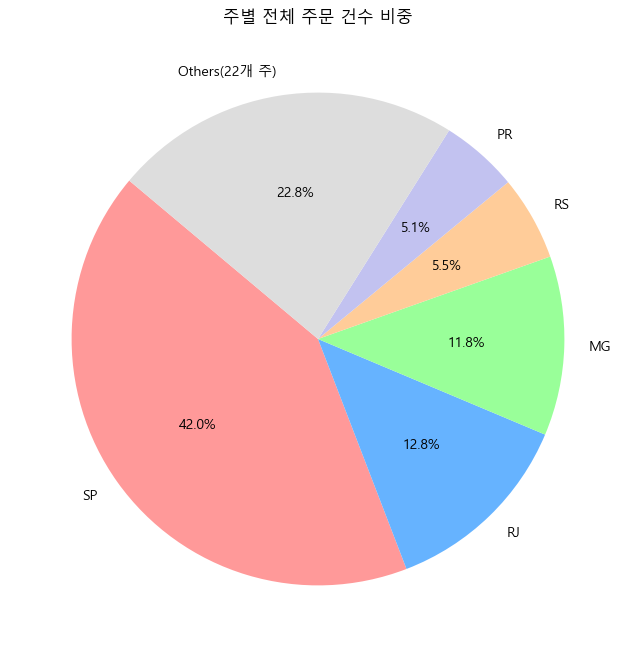

In [28]:
# 대형 주 강조한 파이 차트!

# 주별 전체 주문 건수 집계
order_count = success_orders.groupby('customer_state').size().reset_index(name='전체건수')

# 대형 주 상위 5개 선택
top_states = order_count.nlargest(5, '전체건수')

# 나머지 Others로 합치기
others_count = order_count[~order_count['customer_state'].isin(top_states['customer_state'])]['전체건수'].sum()

# 파이 차트용 데이터 준비
pie_data = top_states.set_index('customer_state')['전체건수'].to_dict()
pie_data['Others(22개 주)'] = others_count

# 파이 차트 그리기
plt.figure(figsize=(8,8))
plt.pie(
    pie_data.values(),
    labels=pie_data.keys(),
    autopct='%1.1f%%',
    startangle=140,
    colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#dddddd']
)
plt.title("주별 전체 주문 건수 비중")
plt.show()

# 혹시 판매자한테 문제가 있나?

In [ ]:
# 'orders'와 'order_items'를 'order_id'로 병합
orders_items = orders.merge(order_items, on='order_id', how='left')

# 'orders_items'와 'sellers'를 'seller_id'로 병합
orders_sellers = orders_items.merge(sellers, on='seller_id', how='left')

# 'orders_sellers'와 'customers'를 'customer_id'로 병합
merged_df = orders_sellers.merge(customers, on='customer_id', how='left')


# 주문, 셀러, 고객 테이블 병합
merged_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,2017-10-06 11:07:15,29.99,8.72,9350.0,maua,SP,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,...,2018-07-30 03:24:27,118.70,22.76,31570.0,belo horizonte,SP,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,...,2018-08-13 08:55:23,159.90,19.22,14840.0,guariba,SP,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,...,2017-11-23 19:45:59,45.00,27.20,31842.0,belo horizonte,MG,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,65266b2da20d04dbe00c5c2d3bb7859e,...,2018-02-19 20:31:37,19.90,8.72,8752.0,mogi das cruzes,SP,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [41]:
# 분석에 필요한 열 선택
df = merged_df[['order_id', 'order_purchase_timestamp', 'order_delivered_customer_date',
                'seller_state', 'customer_state']]

# 날짜 열을 datetime 형식으로 변환
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

# 배송에 성공한 주문만 남기기 (배송 완료일이 있는 경우)
df = df.dropna(subset=['order_delivered_customer_date'])


# 배송 시간(일) 계산
df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.total_seconds() / (60*60*24)

# 판매자 주와 고객 주가 같은지 여부를 나타내는 컬럼 생성
df['same_state'] = (df['seller_state'] == df['customer_state'])

# 'same_state' 컬럼을 기준으로 평균 배송 시간 비교
delivery_time_analysis = df.groupby('same_state')['delivery_time'].mean().reset_index()

# 결과 출력
print("판매자와 고객의 지역 일치 여부에 따른 평균 배송 시간:")
display(delivery_time_analysis)


판매자와 고객의 지역 일치 여부에 따른 평균 배송 시간:


C:\Users\agnes\AppData\Local\Temp\ipykernel_17420\835283533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
C:\Users\agnes\AppData\Local\Temp\ipykernel_17420\835283533.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])


,same_state,delivery_time
0,False,15.049244
1,True,7.925568


In [ ]:
# 지역 내 배송 (Intra-state delivery): 7.9일이라는 평균 배송 시간은 같은 주 내에서의 물류 시스템이 비교적 효율적으로 운영되고 있음을 나타냅니다.

# 지역 간 배송 (Inter-state delivery): 15.0일이라는 시간은 주 경계를 넘어서는 물류 과정에서 상당한 지연이 발생함을 의미합니다. 
# 이는 장거리 운송, 여러 물류 창고를 거치는 과정, 또는 다른 지역의 배송 네트워크로 인계되는 과정에서 문제가 생길 수 있다는 것을 시사합니다.

## 배송량이 많은 SP, RJ에 집중 분석해보기

In [42]:
# 고객 주가 SP 또는 RJ인 데이터만 추출
df_sp_rj = df[df['customer_state'].isin(['SP', 'RJ'])]

display(df_sp_rj.head())
print(f"SP와 RJ 지역의 총 주문 건수: {len(df_sp_rj)}")

# 평균 배송일 비교
result = df_sp_rj.groupby(['customer_state', 'same_state'])['delivery_time'].mean().reset_index()
result


,order_id,order_purchase_timestamp,order_delivered_customer_date,seller_state,customer_state,delivery_time,same_state
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13,SP,SP,8.436574,True
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-16 18:17:02,SP,SP,2.873877,True
7,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30,2017-05-26 12:55:51,SP,RJ,9.989826,False
9,e69bfb5eb88e0ed6a785585b27e16dbf,2017-07-29 11:55:02,2017-08-16 17:14:30,SP,SP,18.221852,True
10,e6ce16cb79ec1d90b1da9085a6118aeb,2017-05-16 19:41:10,2017-05-29 11:18:31,ES,RJ,12.650937,False


SP와 RJ 지역의 총 주문 건수: 60584


,customer_state,same_state,delivery_time
0,RJ,False,15.860248
1,RJ,True,6.566150
2,SP,False,11.286612
3,SP,True,7.926435


,order_id,order_purchase_timestamp,order_delivered_customer_date,seller_state,customer_state,delivery_time,same_state,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,delivery_status
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,SP,RJ,7.614421,False,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-29 00:00:00,97ca439bc427b48bc1cd7177abe71365,5.0,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,배송완료
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,SP,SP,16.216181,True,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-15 00:00:00,7b07bacd811c4117b742569b04ce3580,4.0,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13,배송완료
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,MG,MG,7.948437,True,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-02-05 00:00:00,0c5b33dea94867d1ac402749e5438e8b,5.0,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31,배송완료
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,2018-08-14 13:32:39,SP,SP,6.147269,True,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-20 00:00:00,f4028d019cb58564807486a6aaf33817,4.0,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01,배송완료
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,2017-03-01 16:42:31,PR,SP,25.114352,False,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-17 00:00:00,940144190dcba6351888cafa43f3a3a5,5.0,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59,배송완료


,customer_state,same_state,review_score
0,RJ,다른 주,3.836224
1,RJ,같은 주,4.298327
2,SP,다른 주,4.167060
3,SP,같은 주,4.180344


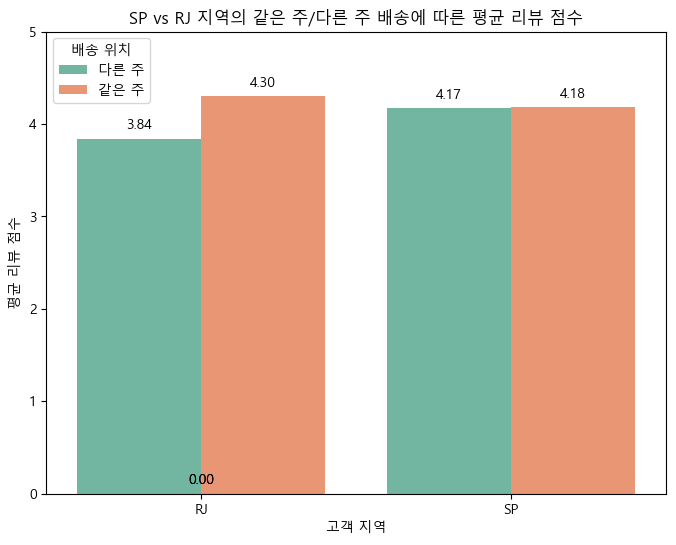

In [ ]:
# df와 주문-리뷰 병합
df_reviews = pd.merge(df, orders_reviews, on='order_id', how='outer', suffixes=('', '_dup'))
# 겹치는 컬럼 삭제
df_reviews = df_reviews.drop(columns=[col for col in df_reviews if col.endswith('_dup')])
display(df_reviews.head())


# SP, RJ 고객만 선택
df_sp_rj = df_reviews[df_reviews['customer_state'].isin(['SP','RJ'])]

# 평균 리뷰 점수 계산 (주별 + same_state별)
result_sp_rj = (
    df_sp_rj.groupby(['customer_state', 'same_state'])['review_score']
    .mean()
    .reset_index()
)


# same_state를 텍스트로 변환 (True/False → 같은 주 / 다른 주)
result_sp_rj['same_state'] = result_sp_rj['same_state'].map({True: '같은 주', False: '다른 주'})

display(result_sp_rj)



# 막대그래프
plt.figure(figsize=(8,6))
ax = sns.barplot(
    data=result_sp_rj,
    x='customer_state',
    y='review_score',
    hue='same_state',
    palette='Set2'
)

# 막대 위에 값 표시
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".2f"),  # 소수 둘째 자리까지 표시
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=10, color='black', xytext=(0, 5),
        textcoords='offset points'
    )

plt.title('SP vs RJ 지역의 같은 주/다른 주 배송에 따른 평균 리뷰 점수')
plt.ylabel('평균 리뷰 점수')
plt.xlabel('고객 지역')
plt.ylim(0, 5)  # 리뷰 점수는 1~5 범위
plt.legend(title='배송 위치')
plt.show()

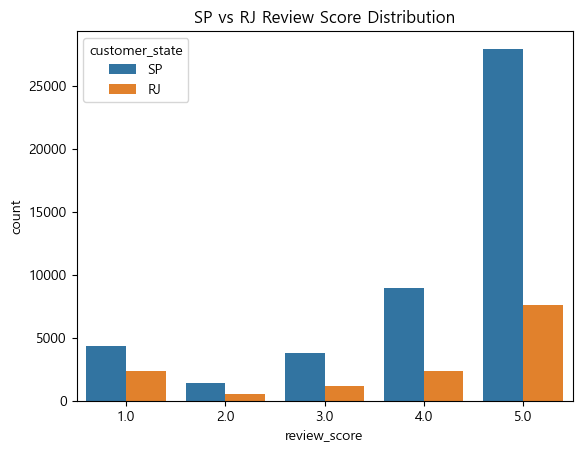

In [76]:
# 리뷰 점수 분포 시각화 
sns.countplot(data=df_sp_rj, x='review_score', hue='customer_state')
plt.title('SP vs RJ Review Score Distribution')
plt.show()

In [128]:
# RJ 지역 데이터만 필터링
rj_orders = df_sp_rj[df_sp_rj['customer_state'] == 'RJ']
display(rj_orders.head())
print('RJ 지역 총 주문 수:', rj_orders['order_id'].count())

# RJ 지역 리뷰 점수 평균
mean_score_rj = rj_orders['review_score'].mean()
print('RJ 지역 리뷰 평균:', (mean_score_rj).round(2))

# 리뷰 점수 평균 이하인 주문만 필터링
low_score_rj = rj_orders[rj_orders['review_score']<= mean_score_rj]
print(f"RJ 지역 리뷰 평균 이하 건수: {low_score_rj['order_id'].count():,}")  # 천 단위 구분

# 평균 배송 소요일 계산
avg_delivery_time_rj = low_score_rj['delivery_time'].mean()
print(f"RJ 지역 리뷰 평균 이하 고객 평균 배송 소요일: {avg_delivery_time_rj:.0f}일")

,order_id,order_purchase_timestamp,order_delivered_customer_date,seller_state,customer_state,delivery_time,same_state,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,delivery_status
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,SP,RJ,7.614421,False,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-29 00:00:00,97ca439bc427b48bc1cd7177abe71365,5.0,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,배송완료
12,0006ec9db01a64e59a68b2c340bf65a7,2018-07-24 17:04:17,2018-07-31 01:04:15,SP,RJ,6.333310,False,5d178120c29c61748ea95bac23cb8f25,delivered,2018-07-24 17:24:20,2018-07-25 11:02:00,2018-08-22 00:00:00,6322c405c0f34bf3ad870fd1a6b1fced,5.0,Boa,Excelente serviço de compras on line.,2018-07-31 00:00:00,2018-08-01 23:05:10,배송완료
22,000f25f4d72195062c040b12dce9a18a,2018-03-07 10:33:13,2018-03-22 16:51:52,SP,RJ,15.262951,False,86ade8ebc14f18dd6c3ea75bd0eb7534,delivered,2018-03-07 11:10:11,2018-03-16 15:58:31,2018-04-11 00:00:00,775038877f3c507777081ff685e14a60,4.0,NaN,NaN,2018-03-23 00:00:00,2018-03-24 04:17:06,배송완료
24,0010b2e5201cc5f1ae7e9c6cc8f5bd00,2017-09-11 17:39:33,2017-09-23 13:21:21,SP,RJ,11.820694,False,57ef317d4818cb42680fc9dfd13867ce,delivered,2017-09-11 18:04:37,2017-09-12 17:02:57,2017-09-27 00:00:00,f55e59915a07435c3615737a15470d96,5.0,NaN,NaN,2017-09-24 00:00:00,2017-09-24 18:35:01,배송완료
26,00119ff934e539cf26f92b9ef0cdfed8,2017-08-06 00:42:49,2017-08-16 17:29:59,PR,RJ,10.699421,False,7dd2e283f47deac853cf70f3b63c8d86,delivered,2017-08-07 00:35:12,2017-08-07 21:12:34,2017-08-31 00:00:00,e79b1300216401c0212ab9b5a66372ff,5.0,NaN,"Recebi o long 10 dias após a compra, e chegou ...",2017-08-17 00:00:00,2017-08-18 00:24:35,배송완료


RJ 지역 총 주문 수: 14224
RJ 지역 리뷰 평균: 3.87
RJ 지역 리뷰 평균 이하 건수: 4,096
RJ 지역 리뷰 평균 이하 고객 평균 배송 소요일: 22일


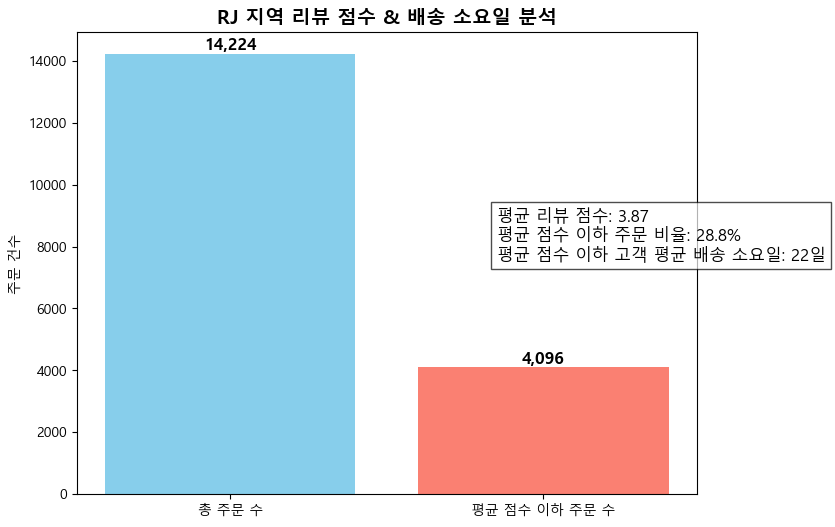

In [132]:
# 값 정리
total_orders = rj_orders['order_id'].count()
mean_score = mean_score_rj.round(2)
low_orders = low_score_rj['order_id'].count()
low_ratio = (low_orders / total_orders) * 100
avg_delivery = avg_delivery_time_rj

# 그래프
fig, ax1 = plt.subplots(figsize=(8,6))

# 1️⃣ 전체 주문 수 vs 평균 이하 주문 수
bars = ax1.bar(['총 주문 수', '평균 점수 이하 주문 수'], 
               [total_orders, low_orders], 
               color=['skyblue','salmon'])

# 수치 표시
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height, 
             f'{height:,}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 2️⃣ 리뷰 평균 & 평균 이하 배송 소요일 텍스트 강조
plt.title('RJ 지역 리뷰 점수 & 배송 소요일 분석', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('주문 건수')

# 텍스트 박스로 요약
textstr = (
    f"평균 리뷰 점수: {mean_score}\n"
    f"평균 점수 이하 주문 비율: {low_ratio:.1f}%\n"
    f"평균 점수 이하 고객 평균 배송 소요일: {avg_delivery:.0f}일"
)
plt.gcf().text(0.65, 0.5, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.show()

In [112]:
print('''

1. RJ 지역 물류 개선 집중 필요
🛣️ 배송 경로 최적화, 🏢 풀필먼트 센터 확충, 🚚 배송업체 조정
평균 배송 소요일 10일로 단축 시 → 리뷰 점수 1.5점 향상 가능
      
2. 고객 만족도 관리
📢 배송 지연 사전 안내, 🎁 보상 정책 적용
리뷰 점수 개선과 재구매율 증가 기대

3. 모니터링
📈 추후 RJ 지역 배송 소요일과 리뷰 점수 추적
개선 효과 확인 후 다른 지역으로 확대 가능''')



1. RJ 지역 물류 개선 집중 필요
🛣️ 배송 경로 최적화, 🏢 풀필먼트 센터 확충, 🚚 배송업체 조정
평균 배송 소요일 10일로 단축 시 → 리뷰 점수 1.5점 향상 가능

2. 고객 만족도 관리
📢 배송 지연 사전 안내, 🎁 보상 정책 적용
리뷰 점수 개선과 재구매율 증가 기대

3. 모니터링
📈 추후 RJ 지역 배송 소요일과 리뷰 점수 추적
개선 효과 확인 후 다른 지역으로 확대 가능
